In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) 
from sidm.tools import ffschema, sidm_processor, utilities, scaleout
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
import mplhep as hep

# Load style sheet
# plt.style.use(hep.style.CMS)  # or ATLAS/LHCb2

# h, bins = np.histogram(np.random.random(1000))
# fig, ax = plt.subplots()
# hep.histplot(h, bins)

utilities.set_plot_style()

In [2]:
#client = scaleout.make_dask_client("tls://localhost:8786")
#client

In [3]:
SIDM_samples = [
    "2Mu2E_100GeV_1p2GeV_9p6mm", 
    "4Mu_100GeV_1p2GeV_9p6mm",
    
    "2Mu2E_1000GeV_0p25GeV_0p02mm",
    "4Mu_1000GeV_0p25GeV_0p02mm"

]


samples = [
    "DYJetsToLL_M10to50", # Background
    "DYJetsToLL_M50",
    
    "QCD_Pt15to20", #Works
    "QCD_Pt20to30", #issue, needs many files to fill all histograms
    "QCD_Pt30to50", #Broken, throws KeyError: 'akjet_ak4PFJetsCHS_jetid'
    "QCD_Pt50to80", #Works
    "QCD_Pt80to120", #Works
    #"QCD_Pt120to170", #Broken, Exception: Failed processing file: WorkItem(dataset='QCD_Pt120to170' ...)
    "QCD_Pt170to300", #Works
    "QCD_Pt300to470", #Works
    "QCD_Pt470to600", #Works
    "QCD_Pt600to800", #Works
    "QCD_Pt800to1000", #Works
    "QCD_Pt1000toInf", #Works
    
    "TTJets",
    
    "WW",
    "WZ",
    "ZZ",
]

for sample in SIDM_samples:
    samples.append(sample)

for sample in samples:
    print("Sample: " + sample)
    
fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=8) #max_files argument was removed, so it defaults to use all the files in each sample
#fileset = utilities.make_fileset(samples, "ffntuple_v2", max_files=1) #CHANGED: background appears to use v2 ntuples instead of v4

Sample: DYJetsToLL_M10to50
Sample: DYJetsToLL_M50
Sample: QCD_Pt15to20
Sample: QCD_Pt20to30
Sample: QCD_Pt30to50
Sample: QCD_Pt50to80
Sample: QCD_Pt80to120
Sample: QCD_Pt170to300
Sample: QCD_Pt300to470
Sample: QCD_Pt470to600
Sample: QCD_Pt600to800
Sample: QCD_Pt800to1000
Sample: QCD_Pt1000toInf
Sample: TTJets
Sample: WW
Sample: WZ
Sample: ZZ
Sample: 2Mu2E_100GeV_1p2GeV_9p6mm
Sample: 4Mu_100GeV_1p2GeV_9p6mm
Sample: 2Mu2E_1000GeV_0p25GeV_0p02mm
Sample: 4Mu_1000GeV_0p25GeV_0p02mm


In [4]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.DaskExecutor(client=client),
    #executor=processor.FuturesExecutor(),
    schema=ffschema.FFSchema,
    #maxchunks=1,
)

channels = [
            "baseNoLj"
           ] # NOTE: the channel used determines the cuts applied. baseNoLj removes the checks for multiple jets.

hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
hist_choice = "base"
collection = utilities.flatten(hist_menu[hist_choice]) #To change the histograms used, swap "base" for the other collections
print(collection)

p = sidm_processor.SidmProcessor(
    channels, [hist_choice]) # not sure if base_plus_gen applies to the background

# test if processor is serializable
import coffea.util as coffea_util
coffea_util.save(p, "processor.coffea")
print(coffea_util.load("processor.coffea"))


output = runner.run(fileset, treename="ffNtuplizer/ffNtuple", processor_instance=p)
out = output["out"]

# Overall, this takes the samples listed in "samples" (section [2]), then processes them in the sidm_processor function.
# Without actual background data, I'm not sure of the format I should use for the samples, or whether the "base_plus_gen" set applies here.
# Regardless, the histograms generated should be stored in the variable "out".


Output()

['pv_n', 'pv_ndof', 'pv_z', 'pv_rho', 'electron_n', 'electron_pt', 'electron_eta_phi', 'photon_n', 'photon_pt', 'photon_eta_phi', 'muon_n', 'muon_pt', 'muon_eta_phi', 'muon_absD0', 'muon_absD0_lowRange', 'dsaMuon_n', 'dsaMuon_pt', 'dsaMuon_eta_phi', 'dsaMuon_absD0', 'dsaMuon_absD0_lowRange', 'lj_n', 'lj_pt', 'egm_lj_pt', 'mu_lj_pt', 'lj0_pt', 'lj1_pt', 'lj0_e', 'lj1_e', 'lj0_dRSpread', 'lj1_dRSpread', 'lj_eta_phi', 'lj_electronN', 'lj_photonN', 'lj_electronPhotonN', 'lj_muonN', 'ljsource_n', 'ljsource_pt', 'ljsource_eta_phi', 'ljsource_charge', 'ljsource_type', 'electron_lj_dR', 'electron_lj_dR_lowRange', 'photon_lj_dR', 'photon_lj_dR_lowRange', 'photon_lj_dR_reallyLowRange', 'muon_lj_dR', 'muon_lj_dR_lowRange', 'dsaMuon_lj_dR', 'dsaMuon_lj_dR_lowRange', 'lj_lj_absdphi', 'lj_lj_invmass', 'lj_lj_invmass_lowRange', 'lj_pfIsolation05', 'lj0_pfIsolation05', 'lj1_pfIsolation05', 'lj_pfIsolationPtNoPU05', 'lj_pfIsolationPt05', 'lj_pfIsolation07', 'lj_pfIsolationPtNoPU07', 'lj_pfIsolationPt07

Output()

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

Warning: electrons not found in this sample. Skipping.

Warning: photons not found in this sample. Skipping.

Warning: genAs_toMu not found in this sample. Skipping.

Warning: genAs_toE not found in this sample. Skipping.

Not applying any cuts to the lepton jets for channel  baseNoLj

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Warning: Unable to apply looseID for muons. Skipping.

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Warning: Unable to apply ifcsczero for dsaMuons. Skipping.

Warning: Unable to apply segOverlap < 0.66 for dsaMuons. Skipping.

Warning: Unable to apply extrapolatedDr > 0.2 for dsaMuons. Skipping.

Warning: Unable to apply isSubsetAnyPFMuon False for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC hits > 12 for dsaMuons. Skipping.

Warning: Unable to apply DT + CSC stations >= 2 for dsaMuons. Skipping.

Warning: Unable to apply ptErrorOverPT < 1 for dsaMuons. Skipping.

Warning: electrons not found in sample. The following cuts will not be applied: ['pT > 10 GeV', '|eta| < 2.4', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   muons :  looseID

Warning: photons not found in sample. The following cuts will not be applied: ['pT > 20 GeV', '|eta| < 2.5', 
'looseID']

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ifcsczero

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  segOverlap < 0.66

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  extrapolatedDr > 0.2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  isSubsetAnyPFMuon False

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC hits > 12

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  DT + CSC stations >= 2

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  ptErrorOverPT < 1

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_eta', 'electron_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 'photon_n']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_pt']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_eta', 'photon_phi']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'muon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'dsaMuon_absD0_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'electron_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_lowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'photon_lj_dR_reallyLowRange']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt05']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPtNoPU07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'lj_pfIsolationPt07']

Warning: a histogram with the following axis names could not be filled and will be skipped: ['channel', 
'ljlj_absdphi', 'lj_pfIsolationPt05']

Warning: cannot fill counter Gen As to muons. Skipping.

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to muons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

In [5]:
# Post-processing, combines background samples into larger sets.
# This applies to cutflows and to histograms

#These flags show whether DY, QCD, and dibosons should be combined into one variable.
bosons = True
QCD = True
DY = True
ttbar = True
#If this is true, all background samples will be combined into one. This automatically disables the other groupings.
TotalBackground = True

if TotalBackground == True:
    DY = False
    QCD = False
    bosons = False
    ttbar = False
    
sample_list = []
if DY == True:
    sample_list.append("DY_Jets")
if QCD == True:
    sample_list.append("QCD_Jets")
if bosons == True:
    sample_list.append("DiBoson_Jets")
if ttbar == True:
    sample_list.append("TT")
    
for sample in samples:
    if (sample[0] != 'D' and DY == True) and (sample[0] != 'Q' and QCD == True) and (sample[0] != 'W' and bosons == True) and (sample[0] != 'Z' and bosons == True) and (sample != 'TT' and ttbar == True):
        sample_list.append(sample)
        
QCD_samples = ["QCD_Pt15to20","QCD_Pt20to30","QCD_Pt30to50","QCD_Pt50to80","QCD_Pt80to120","QCD_Pt120to170",
               "QCD_Pt170to300","QCD_Pt300to470","QCD_Pt470to600","QCD_Pt600to800","QCD_Pt800to1000","QCD_Pt1000toInf"]

# post-processing, adds together all the histograms in the Drell-Yan set into DY_Hists

if DY == True:
    DY_Hists = output['out']["DYJetsToLL_M10to50"]["hists"]
    DY_Cutflow = output['out']["DYJetsToLL_M10to50"]["cutflow"]
    for channel in channels:
        DY_Cutflow[channel] = DY_Cutflow[channel] + output['out']["DYJetsToLL_M50"]["cutflow"][channel]
# Also adds together all QCD samples used
if QCD == True:
    QCD_Hists = output['out']["QCD_Pt15to20"]["hists"]
    QCD_Cutflow = output['out']["QCD_Pt15to20"]["cutflow"]
    for sample in samples:
        if (sample[0] == 'Q') and (sample != "QCD_Pt15to20"):
            for channel in channels:
                QCD_Cutflow[channel] = QCD_Cutflow[channel] + output['out'][sample]["cutflow"][channel]
# Now adds diboson samples together (not sure if TT_ is a diboson, might be quarks)
if bosons == True:
    DiBoson_Hists = output['out']["WW"]["hists"]     
    DiBoson_Cutflow = output['out']["WW"]["cutflow"]
    for channel in channels:
        DiBoson_Cutflow[channel] = DiBoson_Cutflow[channel] + output['out']["ZZ"]["cutflow"][channel]
        DiBoson_Cutflow[channel] = DiBoson_Cutflow[channel] + output['out']["WZ"]["cutflow"][channel]
    
if ttbar == True:
    TT_Hists = output['out']['TTJets']["hists"]
    TT_Cutflow = output['out']['TTJets']["cutflow"]
    
if TotalBackground == True:
    bg_Hists = output['out']["DYJetsToLL_M10to50"]["hists"]
    bg_Cutflow = output['out']["DYJetsToLL_M10to50"]["cutflow"]
    for sample in samples:
        if (sample[0] == 'D') or (sample[0] == 'Q') or (sample[0] == 'W') or (sample[0] == 'Z') and (sample != "DYJetsToLL_M10to50"):
            for channel in channels:
                bg_Cutflow[channel] = bg_Cutflow[channel] + output['out'][sample]["cutflow"][channel]
                
                
hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
collection = utilities.flatten(hist_menu[hist_choice]) #To change the histograms used, swap "base" for the other collections
#collection.remove("lj_pfiso") #lj_pfiso is bugged, this line removes it

for hist_name in collection:
    if DY == True:
        #print("Adding " + hist_name + " to DY_Hists")
        DY_Hists[hist_name] = DY_Hists[hist_name] + output['out']["DYJetsToLL_M50"]["hists"][hist_name]
    if QCD == True:
        for sample in samples:
            if (sample[0] == 'Q') and (sample != "QCD_Pt15to20"):
                QCD_Hists[hist_name] = QCD_Hists[hist_name] + output['out'][sample]["hists"][hist_name]
    if bosons == True:
        DiBoson_Hists[hist_name] = DiBoson_Hists[hist_name] + output['out']["WZ"]["hists"][hist_name]
        DiBoson_Hists[hist_name] = DiBoson_Hists[hist_name] + output['out']["ZZ"]["hists"][hist_name]
    if TotalBackground == True:
        for sample in samples:
            if (sample[0] == 'D') or (sample[0] == 'Q') or (sample[0] == 'W') or (sample[0] == 'Z') and (sample != "DYJetsToLL_M10to50"):
                bg_Hists[hist_name] = bg_Hists[hist_name] + output['out'][sample]["hists"][hist_name]
                
            #print("Adding  " + sample + ' ' + hist_name + " histogram to QCD_Pt15to20")
# IMPORTANT: This sets DY_10to50 as the base for the DY_Hists. When DY_Hists is changed, so is DY_10to50. This
#            shouldn't matter, since the only one used will be DY_Hists in most cases, but this needs to be fixed.
#            The same issue is present with QCD_15to20 and QCD_Hists.

#IMPORTANT: I've commented out the lj_pfiso histogram in hist_collections.yaml, since it is consistently giving an error

In [6]:
#This defines a function to break down the samples and make individual subplots for each one.
#First, it makes a list of all samples, replacing the individual background ones with any aggregates
#(DY, QCD, bosons). This does not include the total background one, since that can be plotted with a single function
#rather than this process. Next, it cycles through the list and plots all the samples.
#Note to fix: if one of the aggregates is disabled, the ordering of the plots breaks.
#Also, the argument nrow is now determined from number of samples and number of columns, so the input parameter is unnecessary.
# I should also set the specific range as a parameter. For now, it uses [ :1200j], and that seems to change as needed, but it could be an issue in the future.
sample_list = []
if DY == True:
    sample_list.append("DY_Jets")
if QCD == True:
    sample_list.append("QCD_Jets")
if bosons == True:
    sample_list.append("DiBoson_Jets")
if ttbar == True:
    sample_list.append("TTJets")
if TotalBackground == True:
    sample_list.append("Total Background")
for sample in samples:
    if (sample[0] != 'D') and (sample[0] != 'Q') and (sample[0] != 'W') and (sample[0] != 'Z') and (sample[0] != 'T'):
        sample_list.append(sample)
        
def plotSamples(hists, channel, errorBars, densityPlot, nrow=2, ncol=4, samples=sample_list, fullBg=TotalBackground):
    #Note that nrow gets overwritten. Might want to remove that.
    if fullBg == False:
        nplots = len(samples)
        nrow = (nplots-1)//ncol + 1
        if (nplots <= 5):
            ncol = nplots
            nrow = 1
        plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
        counter = 1
        print("Now plotting " + hists[0], end='')
        while counter < len(hists):
            print(" and " + hists[counter], end='')
            counter += 1
        print('.')
        
        DY_flag = False
        QCD_flag = False
        DB_flag = False
        TT_flag = False
        totBg_flag = False
        
        for i in range(nplots):
            skip = False
            plt.subplot(nrow, ncol, i+1)
            plt.rcParams['font.size'] = 16
            
            if (DY == True and DY_flag == False and skip != True):
                for hist in hists:
                    utilities.plot(DY_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])
                skip = True
                DY_flag = True
            if (QCD == True and QCD_flag == False and skip != True):
                for hist in hists:
                    utilities.plot(QCD_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])
                skip = True
                QCD_flag = True
            if (bosons == True and DB_flag == False and skip != True):
                for hist in hists:
                    utilities.plot(DiBoson_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])
                skip = True
                DB_flag = True
            if (ttbar == True and TT_flag == False and skip != True):
                for hist in hists:
                    utilities.plot(TT_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])
                skip = True
                TT_flag = True
            elif (i <= nplots and skip != True):
                for hist in hists:
                    utilities.plot(out[samples[i]]["hists"][hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])

    else: #case that background is combined together
        nplots = len(SIDM_samples) + 1
        if nplots <= 5:
            ncol = nplots
            nrow = 1
        else:
            nrow = (nplots-1)//ncol + 1
        plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
        counter = 1
        print("Now plotting " + hists[0], end='')
        while counter < len(hists):
            print(" and " + hists[counter], end='')
            counter += 1
        print('.')
        for i in range(nplots):
            plt.subplot(nrow, ncol, i+1)
            plt.rcParams['font.size'] = 16
            
            
            
            if i == 0:
                for hist in hists:
                    utilities.plot(bg_Hists[hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                print(i)
                print(samples[i])
                plt.title(samples[i])
                
                
                
            elif i <= nplots:
                for hist in hists:
                    utilities.plot(out[samples[i]]["hists"][hist][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                if len(hists) > 1:
                    plt.legend(hists)
                plt.title(samples[i])

In [7]:
def plotHists(hists, channel, errorBars, densityPlot, samples=sample_list, fullBg=TotalBackground):
    #Note that nrow gets overwritten. Might want to remove that.
    nplots = len(hists)
    if (nplots <= 5):
        ncol = nplots
        nrow = 1
    else:
        ncol = 4
        nrow = (nplots-1)//ncol + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    for i in range(nplots):
        DY_Flag = False
        QCD_Flag = False
        DB_Flag = False
        TT_Flag = False
        Tot_BG_Flag = False
        plt.subplot(nrow, ncol, i+1)
        plt.rcParams['font.size'] = 16
        j = 0
        while j < len(samples):
            if DY == True and DY_Flag == False:
                utilities.plot(DY_Hists[hists[i]][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                j = j + 1
                DY_Flag = True
            if QCD == True and QCD_Flag == False:
                utilities.plot(QCD_Hists[hists[i]][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                j = j + 1
                QCD_Flag = True
            if bosons == True and DB_Flag == False:
                utilities.plot(DiBoson_Hists[hists[i]][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                j = j + 1
                DB_Flag = True
            if ttbar == True and TT_Flag == False:
                utilities.plot(TT_Hists[hists[i]][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                j = j+1
                TT_Flag = True
            if fullBg == True and Tot_BG_Flag == False:
                utilities.plot(bg_Hists[hists[i]][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
                j = j + 1
                Tot_BG_Flag = True
            utilities.plot(out[samples[j]]["hists"][hists[i]][channel, :1200j], yerr=errorBars, density=densityPlot, flow='none')
            j = j + 1
        if len(samples) > 1:
            plt.legend(samples)
        plt.title(hists[i])

Now plotting lj_lj_invmass.
0
Total Background


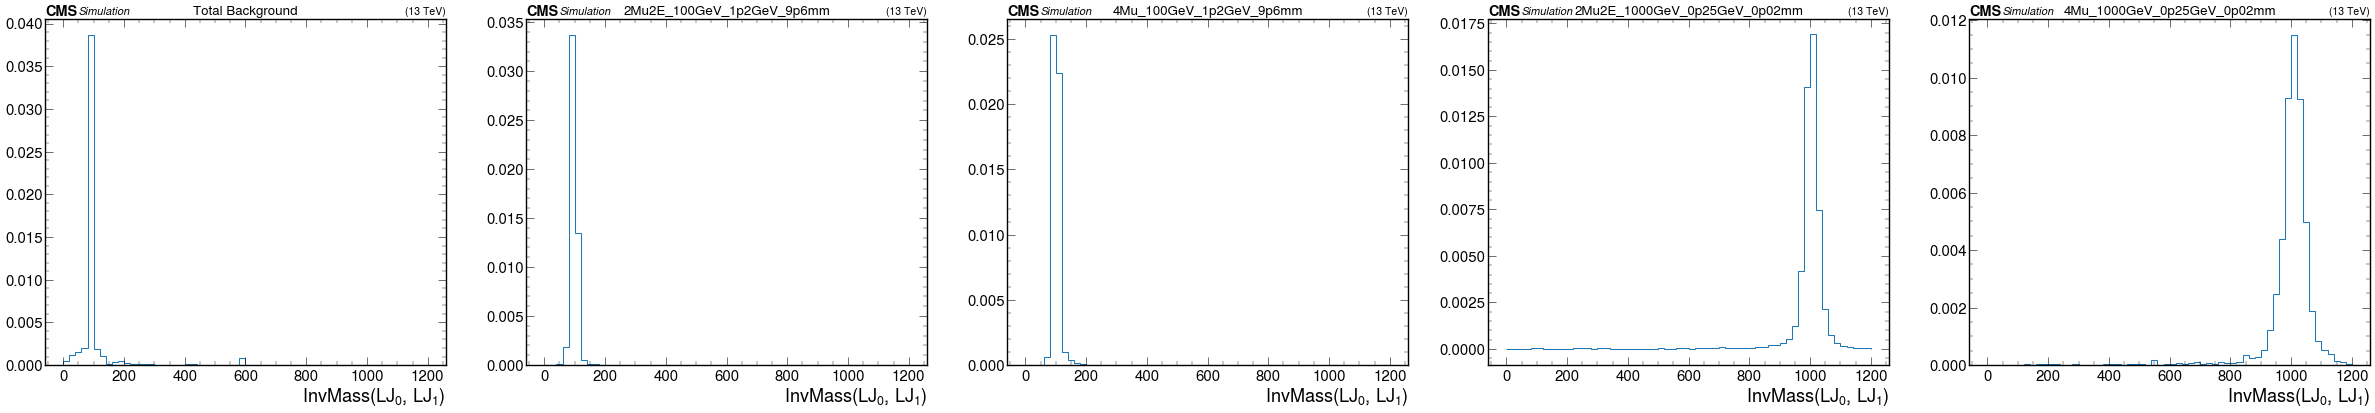

In [8]:
plotSamples(["lj_lj_invmass"], "baseNoLj", False, True, sample_list)

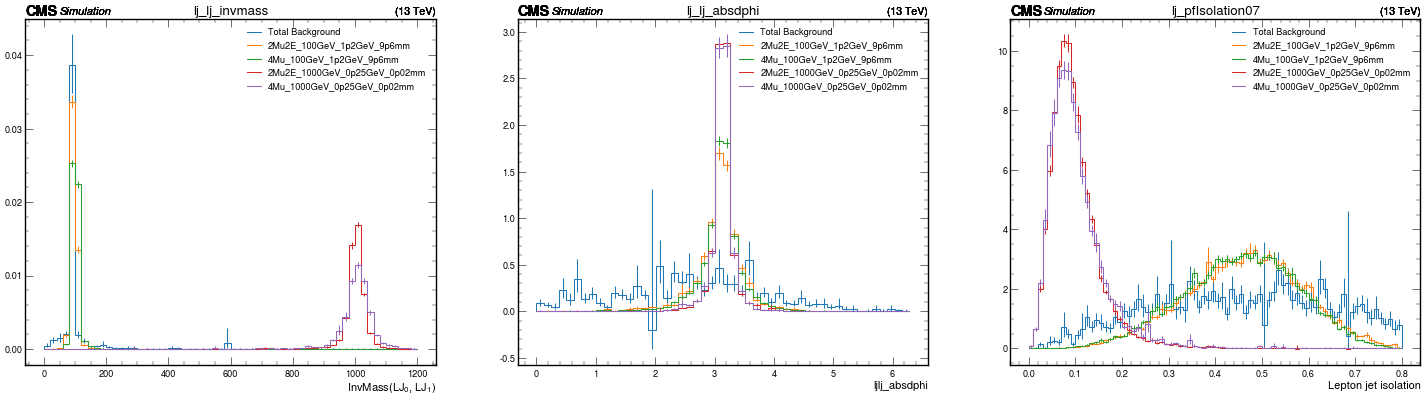

In [10]:
plotHists(["lj_lj_invmass", "lj_lj_absdphi", "lj_pfIsolation07"], "baseNoLj", True, True, sample_list)